In [1]:
# TODO


The purpose of this notebook is to find a set of substrate annotation labels that divide the transporters in *E. coli* into classes which are large enough for training ML models. The labels should have minimal overlap in terms of annotated proteins, and span as much of the genome as possible. Each selected label will have a minimal number of annotated proteins.

We will try to a automate this process with a greedy algorithm removes the annotation with the largest overlap to the rest of the dataset in every step.

There are several sources of substrate annotations:

- ChEBI annotations in TCDB
- ChEBI annotations from EBI
- Gene Ontology Molecular function
- A combination of the above, for example by filtering proteins for transmembrane transport GO terms and then annotating with EBI.

## Dataset

As a first dataset, we will use *E. coli* again. Trying a version of this dataset that is clustered with cd-hit, and a meta-organism dataset, could also be interesting. 

In [2]:
from subpred.util import load_df

df_uniprot = load_df("uniprot")
df_uniprot


gene_names  \
Uniprot                                         
A0A0C5B5G6                            MT-RNR1   
A0A1B0GTW7                        CIROP LMLN2   
A0JNW5      BLTP3B KIAA0701 SHIP164 UHRF1BP1L   
A0JP26                                 POTEB3   
A0PK11                                  CLRN2   
...                                       ...   
X5L4R4                                  NOD-2   
X5MBL2                                  GT34D   
X5MFI4                                  GT34D   
X5MI49                                  GT34A   
X5MPI5                                  GT34C   

                                                protein_names  reviewed  \
Uniprot                                                                   
A0A0C5B5G6  Mitochondrial-derived peptide MOTS-c (Mitochon...      True   
A0A1B0GTW7  Ciliated left-right organizer metallopeptidase...      True   
A0JNW5      Bridge-like lipid transfer protein family memb...      True   
A0JP26                   POTE ankyrin domain family member B3      True   
A0PK11                                               Clarin-2      True   
...                                                       ...       ...   
X5L4R4      Nucleotide-binding oligomerization domain-cont...     False   
X5MBL2      Putative galacto(Gluco)mannan alpha-1,6-galact...     False   
X5MFI4      Putative galacto(Gluco)mannan alpha-1,6-galact...     False   
X5MI49      Putative galacto(Gluco)mannan alpha-1,6-galact...     False   
X5MPI5                Xyloglucan alpha-1,6-xylosyltransferase     False   

            protein_existence  \
Uniprot                         
A0A0C5B5G6                  1   
A0A1B0GTW7                  1   
A0JNW5                      1   
A0JP26                      1   
A0PK11                      1   
...                       ...   
X5L4R4                      2   
X5MBL2                      2   
X5MFI4                      2   
X5MI49                      2   
X5MPI5                      2   

                                                     sequence  organism_id  
Uniprot                                                                     
A0A0C5B5G6                                   MRWQEMGYIFYPRKLR         9606  
A0A1B0GTW7  MLLLLLLLLLLPPLVLRVAASRCLHDETQKSVSLLRPPFSQLPSKS...         9606  
A0JNW5      MAGIIKKQILKHLSRFTKNLSPDKINLSTLKGEGELKNLELDEEVL...         9606  
A0JP26      MVAEVCSMPAASAVKKPFDLRSKMGKWCHHRFPCCRGSGKSNMGTS...         9606  
A0PK11      MPGWFKKAWYGLASLLSFSSFILIIVALVVPHWLSGKILCQTGVDL...         9606  
...                                                       ...          ...  
X5L4R4      MSPGCYKGWPFNCHLSHEEDKRRNETLLQEAETSNLQITASFVSGL...       586796  
X5MBL2      KVLYDRAFNSSDDQSALVYLLLKEKDKWADRIFIEHKYYLNGYWLD...         3352  
X5MFI4      MDEDVLCKGPLHGGSARSLKGSLKRLKRIMESLNDGLIFMGGAVSA...         3352  
X5MI49      MVNDSKLETISGNMVQKRKSFDGLPFWTVSIAGGLLLCWSLWRICF...         3352  
X5MPI5      MRESVKRGLPSVRGPANGRSLALPKARSIQKTFNNLKITILCGFVT...         3352  

[1021957 rows x 6 columns]

In [3]:
df_uniprot_ecoli = df_uniprot[df_uniprot.organism_id == 83333].drop(
    "organism_id", axis=1
)
df_uniprot_ecoli


gene_names  \
Uniprot                              
P00509           aspC b0928 JW0911   
P00803           lepB b2568 JW2552   
P00804       lspA lsp b0027 JW0025   
P00861           lysA b2838 JW2806   
P00946       manA pmi b1613 JW1605   
...                            ...   
P76154           ydfK b1544 JW1537   
P0AEG8           dsrB b1952 JW1936   
P33668           ybbC b0498 JW0487   
A0A7H2C7B0     speFL ECK4660 b4803   
A0A0A6YVN8  D-tagatose 3-epimerase   

                                                protein_names  reviewed  \
Uniprot                                                                   
P00509      Aspartate aminotransferase (AspAT) (EC 2.6.1.1...      True   
P00803      Signal peptidase I (SPase I) (EC 3.4.21.89) (L...      True   
P00804      Lipoprotein signal peptidase (EC 3.4.23.36) (P...      True   
P00861      Diaminopimelate decarboxylase (DAP decarboxyla...      True   
P00946      Mannose-6-phosphate isomerase (EC 5.3.1.8) (Ph...      True   
...                                                       ...       ...   
P76154                                Cold shock protein YdfK      True   
P0AEG8                                           Protein DsrB      True   
P33668                           Uncharacterized protein YbbC      True   
A0A7H2C7B0        Leader peptide SpeFL (Arrest peptide SpeFL)     False   
A0A0A6YVN8                             D-tagatose 3-epimerase     False   

            protein_existence  \
Uniprot                         
P00509                      1   
P00803                      1   
P00804                      1   
P00861                      1   
P00946                      1   
...                       ...   
P76154                      2   
P0AEG8                      2   
P33668                      2   
A0A7H2C7B0                  2   
A0A0A6YVN8                  1   

                                                     sequence  
Uniprot                                                        
P00509      MFENITAAPADPILGLADLFRADERPGKINLGIGVYKDETGKTPVL...  
P00803      MANMFALILVIATLVTGILWCVDKFFFAPKRRERQAAAQAAAGDSL...  
P00804      MSQSICSTGLRWLWLVVVVLIIDLGSKYLILQNFALGDTVPLFPSL...  
P00861      MPHSLFSTDTDLTAENLLRLPAEFGCPVWVYDAQIIRRQIAALKQF...  
P00946      MQKLINSVQNYAWGSKTALTELYGMENPSSQPMAELWMGAHPKSSS...  
...                                                       ...  
P76154      MKSKDTLKWFPAQLPEVRIILGDAVVEVAKQGRPINTRTLLDYIEG...  
P0AEG8      MKVNDRVTVKTDGGPRRPGVVLAVEEFSEGTMYLVSLEDYPLGIWF...  
P33668      MKYSSIFSMLSFFILFACNETAVYGSDENIIFMRYVEKLHLDKYSV...  
A0A7H2C7B0                 MENNSRTMPHIRRTTHIMKFAHRNSFDFHFFNAR  
A0A0A6YVN8  MNKVGMFYTYWSTEWMVDFPATAKRIAGLGFDLMEISLGEFHNLSD...  

[3284 rows x 5 columns]

Checking for sparse data:

In [4]:
assert not df_uniprot_ecoli.gene_names.isnull().any()
assert not df_uniprot_ecoli.protein_names.isnull().any()
assert not df_uniprot_ecoli.sequence.isnull().any()


What is the distribution among Swissprot and Trembl?

In [5]:
df_uniprot_ecoli[["reviewed", "protein_existence"]].groupby(
    ["reviewed", "protein_existence"]
).apply(len)


reviewed  protein_existence
False     1                       1
          2                       1
True      1                    3118
          2                     164
dtype: int64

In [6]:
df_uniprot_ecoli[~df_uniprot_ecoli.reviewed]


gene_names  \
Uniprot                              
A0A7H2C7B0     speFL ECK4660 b4803   
A0A0A6YVN8  D-tagatose 3-epimerase   

                                          protein_names  reviewed  \
Uniprot                                                             
A0A7H2C7B0  Leader peptide SpeFL (Arrest peptide SpeFL)     False   
A0A0A6YVN8                       D-tagatose 3-epimerase     False   

            protein_existence  \
Uniprot                         
A0A7H2C7B0                  2   
A0A0A6YVN8                  1   

                                                     sequence  
Uniprot                                                        
A0A7H2C7B0                 MENNSRTMPHIRRTTHIMKFAHRNSFDFHFFNAR  
A0A0A6YVN8  MNKVGMFYTYWSTEWMVDFPATAKRIAGLGFDLMEISLGEFHNLSD...

Since Trembl only adds two proteins, we go with Swissprot instead:

In [7]:
df_uniprot_ecoli = df_uniprot_ecoli[df_uniprot_ecoli.reviewed].drop("reviewed", axis=1)


One of the proteins was actually a relatively short peptide. What are the sequence lengths in the dataset, and are there any outliers?

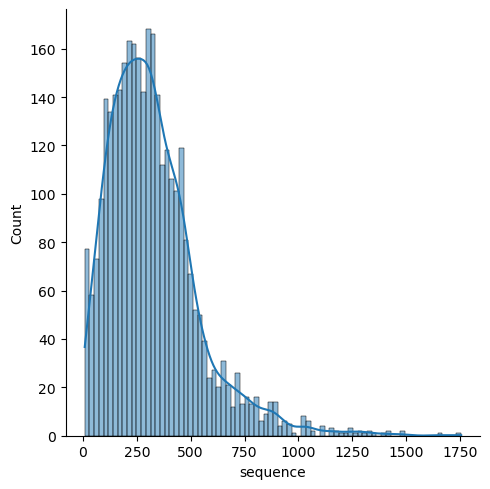

In [8]:
import seaborn as sns

len_sequences = df_uniprot_ecoli.sequence.apply(len)
sns.displot(len_sequences, kde=True, bins=80)


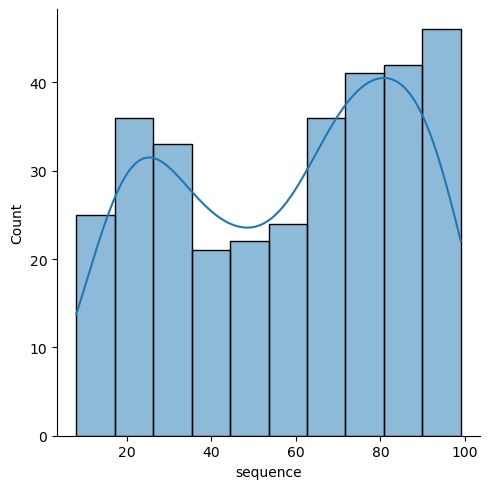

In [9]:
sns.displot(len_sequences[len_sequences < 100], kde=True)


There seems to be an increased number of proteins with sequences with around 20 amino acids. Some of them only have a very small number of amino acids, which would make sequence-based features less reliable. They don't seem to be part of the transporter dataset, but we should still check that dataset for sequence lengths.

In [10]:
df_uniprot_ecoli[df_uniprot_ecoli.sequence.apply(len) < 25]


gene_names  \
Uniprot                            
C1P617       ibsE b4666 JW3023.2   
C1P607       ibsA b4667 JW2058.1   
C1P615       ibsC b4665 JW2879.1   
C1P603       yoaJ b4675 JW5292.2   
P0DSH2                baxL b4794   
C1P610       ypdK b4680 JW2375.1   
P0AD89    tnaC tnaL b3707 JW3685   
P0AD92   trpL trpEE b1265 JW1257   
P0DSG0                pssL b4782   
P0DPN0                yahV b4730   
P0DPN6                yliM b4736   
P0DPO6                yddY b4746   
P0DSE6                ybgV b4768   
P0DSF7                yoaM b4779   
P0DSG4                yqhJ b4786   
P0DSG7                yhgP b4789   
P0DSG9                yriA b4791   
P0DSH5                yicU b4797   
P0DV21                ytgB b4822   
P0DV22                ytiE b4823   
C1P619       ilvX b4669 JW3740.1   
C1P621       yjeV b4670 JW5740.1   
P0DPN7                ymdG b4737   
P0DSE7                ybiE b4769   
P0DSH8                ytgA b4800   
P0DUW1                ymgN b4816   
P0DV19                yrfJ b4820   
C1P604       yobI b4677 JW1850.1   
P0DPM5                yabR b4726   
P0DPP4                yqfH b4753   
P0DSE8                yljB b4770   
P0DSG1                yfiS b4783   
P0DSH0                yriB b4792   
P0DSH1                ysaE b4793   
P0DSH6                ysdE b4798   
P0DV23                ytjE b4824   
A5A621       ypfM b4606 JW2454.1   
C1P606       yoeI b4678 JW5330.1   
P0DPM7                yadW b4728   
P0DPN8                ymgK b4738   
P0DPO9                ynfR b4749   
P0DSE5                ytiB b4767   
P0DSF2                yncP b4774   
P0DSG6                yhgO b4788   
P0DUW3                yoeJ b4818   
P0DV20                ytcB b4821   
C1P600       ynbG b4674 JW1395.1   
P0CD93       ymjD b4673 JW5960.1   
P0DPM6                yacM b4727   
P0DSE3                yadX b4765   
P0DSE9                ychT b4771   
P0DSF1                ynaN b4773   
P0DSF6                yecV b4778   
P0DSF9                evgL b4781   
P0DSH7                ysgD b4799   
P0DSH9                ykiE b4801   
P0DUW0                ykfO b4815   

                                          protein_names  protein_existence  \
Uniprot                                                                      
C1P617                         Small toxic protein IbsE                  2   
C1P607                         Small toxic protein IbsA                  2   
C1P615                         Small toxic protein IbsC                  2   
C1P603                     Uncharacterized protein YoaJ                  1   
P0DSH2   Putative translational regulatory protein BaxL                  1   
C1P610            Uncharacterized membrane protein YpdK                  1   
P0AD89              Tryptophanase operon leader peptide                  1   
P0AD92                        trp operon leader peptide                  1   
P0DSG0                                     Protein PssL                  1   
P0DPN0                                     Protein YahV                  1   
P0DPN6                                     Protein YliM                  1   
P0DPO6                                     Protein YddY                  1   
P0DSE6                                     Protein YbgV                  1   
P0DSF7                                     Protein YoaM                  1   
P0DSG4                                     Protein YqhJ                  1   
P0DSG7                                     Protein YhgP                  1   
P0DSG9                                     Protein YriA                  1   
P0DSH5                                     Protein YicU                  1   
P0DV21                                     Protein YtgB                  1   
P0DV22                                     Protein YtiE                  1   
C1P619                     Uncharacterized protein IlvX                  1   
C1P621                     Uncharacterized protein YjeV                  1   
P0DPN7                   

## Annotations

### GO

In [11]:
df_goa_uniprot = load_df("go")
df_goa_uniprot


Uniprot    qualifier       go_id evidence_code aspect
0        A0A009FND8      enables  GO:0000166           IEA      F
1        A0A009FND8      enables  GO:0005524           IEA      F
2        A0A009FND8      enables  GO:0051082           IEA      F
3        A0A009FND8      enables  GO:0140662           IEA      F
4        A0A009FND8  involved_in  GO:0006457           IEA      P
...             ...          ...         ...           ...    ...
7452013      Z9JND5      enables  GO:0000166           IEA      F
7452014      Z9JND5      enables  GO:0005524           IEA      F
7452015      Z9JND5      enables  GO:0051082           IEA      F
7452016      Z9JND5      enables  GO:0140662           IEA      F
7452017      Z9JND5  involved_in  GO:0006457           IEA      P

[7452018 rows x 5 columns]

In [12]:
df_goa_uniprot_ecoli = df_goa_uniprot[
    df_goa_uniprot.Uniprot.isin(df_uniprot_ecoli.index)
]
# df_goa_uniprot_ecoli = df_goa_uniprot_ecoli.assign(
#     evidence_description=df_goa_uniprot_ecoli.evidence_code.map(
#         EVIDENCE_CODE_TO_DESCRIPTION
#     )
# )
df_goa_uniprot_ecoli = df_goa_uniprot_ecoli.reset_index(drop=True)
df_goa_uniprot_ecoli


Uniprot                   qualifier       go_id evidence_code aspect
0      A5A615                  located_in  GO:0005886           IDA      C
1      A5A615                  located_in  GO:0005886           IEA      C
2      A5A615                  located_in  GO:0005886           RCA      C
3      A5A615                  located_in  GO:0016020           IEA      C
4      A5A616  acts_upstream_of_or_within  GO:0010350           IEP      P
...       ...                         ...         ...           ...    ...
40133  Q93K97                 involved_in  GO:0006753           IBA      P
40134  Q93K97                 involved_in  GO:0019693           IBA      P
40135  Q93K97                is_active_in  GO:0005829           IBA      C
40136  Q93K97                  located_in  GO:0005829           HDA      C
40137  Q93K97                  located_in  GO:0005829           IDA      C

[40138 rows x 5 columns]

Here, we add the ancestors, now using the OBO file instead of the OWL file, along with a new package.

In [13]:
# TODO ancestors
# TODO deprecated terms (ignore_obsolete parameter)
# TODO maybe use older version of obo that matches Uniprot version?


In [14]:
import obonet
import networkx as nx

graph_go = obonet.read_obo("../data/raw/ontologies/go.obo", ignore_obsolete=True)
# graph_go = obonet.read_obo("../obo_parser/go_2023_01.obo")


In [15]:
id_to_name = {id: data["name"] for id, data in graph_go.nodes(data=True)}
name_to_id = {name: id for id, name in id_to_name.items()}


Are all the terms in the graph?

In [16]:
# check if all go terms are in graph
df_goa_uniprot_ecoli[~df_goa_uniprot_ecoli.go_id.isin(set(graph_go.nodes()))].shape[0]


0

Yes, we don't need to load any deprecated terms.

#### NetworkX Package

https://networkx.org/documentation/stable/reference/classes/multidigraph.html

Interesting functions:

- G.subgraph(nodes)
- G.edge_subgraph(nodes)
- G.edges(keys=True)
- G.nodes(data=True)
- G.predecessors(node)
- G.successors(node)
- nx.has_path(G, source, end)
- nx.is_directed_acyclic_graph(G)
- nx.descendants_at_distance(G, node, d)
- nx.descendants(G, node), higher nodes
- nx.ancestors(G, node): lower nodes
- nx.find_cycle(G) throws exception

Are the edges annotated with the type of relation?

In [17]:
list(graph_go.edges(data=True, keys=True))[:20]


[('GO:0000001', 'GO:0048308', 'is_a', {}),
 ('GO:0000001', 'GO:0048311', 'is_a', {}),
 ('GO:0000002', 'GO:0007005', 'is_a', {}),
 ('GO:0000003', 'GO:0008150', 'is_a', {}),
 ('GO:0000006', 'GO:0005385', 'is_a', {}),
 ('GO:0000007', 'GO:0005385', 'is_a', {}),
 ('GO:0000009', 'GO:0000030', 'is_a', {}),
 ('GO:0000010', 'GO:0004659', 'is_a', {}),
 ('GO:0000011', 'GO:0007033', 'is_a', {}),
 ('GO:0000011', 'GO:0048308', 'is_a', {}),
 ('GO:0000012', 'GO:0006281', 'is_a', {}),
 ('GO:0000014', 'GO:0004520', 'is_a', {}),
 ('GO:0000015', 'GO:1902494', 'is_a', {}),
 ('GO:0000015', 'GO:0005829', 'part_of', {}),
 ('GO:0000016', 'GO:0004553', 'is_a', {}),
 ('GO:0000017', 'GO:0042946', 'is_a', {}),
 ('GO:0000018', 'GO:0051052', 'is_a', {}),
 ('GO:0000018', 'GO:0006310', 'regulates', {}),
 ('GO:0000019', 'GO:0000018', 'is_a', {}),
 ('GO:0000019', 'GO:0006312', 'regulates', {})]

Yes, does this mean that the ancestors of a MF term also include BP?

In [18]:
print(
    "path from transmembrane transporter activity to biological process?",
    nx.has_path(graph_go, "GO:0022857", "GO:0008150"),
)
print(
    "path from transmembrane transporter activity to molecular function?",
    nx.has_path(graph_go, "GO:0022857", "GO:0003674"),
)
print(
    "path from transmembrane transporter activity to cellular component?",
    nx.has_path(graph_go, "GO:0022857", "GO:0005575"),
)


path from transmembrane transporter activity to biological process? True
path from transmembrane transporter activity to molecular function? True
path from transmembrane transporter activity to cellular component? False


Yes, that is the case. If we want the direct ancestors of a term in the same ontology (e.g. MF), we have to filter the graph for MF nodes first.

Which namespaces are there?

In [19]:
{data["namespace"] for _, data in graph_go.nodes(data=True)}


{'biological_process', 'cellular_component', 'molecular_function'}

Creating subgraph that only contains MF nodes:

In [20]:
# graph_go_mf
nodes_mf = [
    node
    for node, data in graph_go.nodes(data=True)
    if data["namespace"] == "molecular_function"
]
graph_go_mf = graph_go.subgraph(nodes=nodes_mf)


Did it work? Are there BP terms related to transmembrane transporter activity?

In [21]:
# TODO delete cycles, then bfs?
# TODO remove leaves?
tmtp_ancestors = nx.ancestors(
    graph_go_mf, name_to_id["transmembrane transporter activity"]
)
tmtp_descendants = nx.descendants(
    graph_go_mf, name_to_id["transmembrane transporter activity"]
)

{
    data["namespace"]
    for _, data in graph_go_mf.subgraph(tmtp_ancestors | tmtp_descendants).nodes(
        data=True
    )
}


{'molecular_function'}

Does the set of ancestor/descendants nodes contain the node itself? This was the case in owlready2.

In [22]:
print(
    "source in ancestors:",
    name_to_id["transmembrane transporter activity"] in tmtp_ancestors,
)
print(
    "source in descendants:",
    name_to_id["transmembrane transporter activity"] in tmtp_descendants,
)


source in ancestors: False
source in descendants: False


Is the graph acyclic? Cycles can cause problems when traversing the graph. 

https://networkx.org/documentation/stable/reference/algorithms/cycles.html

In [23]:
print("entire go acyclic?", nx.is_directed_acyclic_graph(graph_go))
print("go-mf acyclic?", nx.is_directed_acyclic_graph(graph_go_mf))


entire go acyclic? False
go-mf acyclic? False


What if we only look at the transmembrane transporter annotations?

In [24]:
graph_go_mf_tmtp = graph_go_mf.subgraph(tmtp_ancestors | {name_to_id["transmembrane transporter activity"]})
print("transporter subgraph acyclic?", nx.is_directed_acyclic_graph(graph_go_mf_tmtp))

transporter subgraph acyclic? True


We should also look at the edge annotations, i.e. the types of relations in the subgraph:

In [25]:
from collections import Counter

Counter([edge[2] for edge in list(graph_go_mf_tmtp.edges(keys=True))])


Counter({'is_a': 1885, 'part_of': 1})

Only one of the edges that are left does not use the is_a relation. Which one is that?

In [26]:
source, target, relation = [
    edge for edge in list(graph_go_mf_tmtp.edges(keys=True)) if edge[2] == "part_of"
][0]
id_to_name[source], relation, id_to_name[target]


('gap junction hemi-channel activity',
 'part_of',
 'gap junction channel activity')

That looks okay.

####  Annotating the graph with E. Coli data:

Now we will add the number of proteins annotated with a particular annotation in E Coli

In [27]:
from copy import deepcopy

graph_go_mf_tmtp_ecoli = deepcopy(graph_go_mf_tmtp)


Filtering 

In [28]:
# TODO add ancestors
# TODO the term itself is not a part of it
df_goa_uniprot_ecoli_tmtp = df_goa_uniprot_ecoli[
    df_goa_uniprot_ecoli.go_id.isin(set(graph_go_mf_tmtp_ecoli.nodes()))
]
df_goa_uniprot_ecoli_tmtp = df_goa_uniprot_ecoli_tmtp[
    df_goa_uniprot_ecoli_tmtp.qualifier == "enables"
].drop("qualifier", axis=1)
df_goa_uniprot_ecoli_tmtp = df_goa_uniprot_ecoli_tmtp.drop("aspect", axis=1)
df_goa_uniprot_ecoli_tmtp = df_goa_uniprot_ecoli_tmtp.reset_index(drop=True)
df_goa_uniprot_ecoli_tmtp


Uniprot       go_id evidence_code
0     A5A627  GO:0005253           IDA
1     A5A627  GO:0005253           IEA
2     P00393  GO:0008137           IDA
3     P00550  GO:0008982           IEA
4     P00550  GO:0022872           IEA
...      ...         ...           ...
1397  Q59385  GO:0015662           IDA
1398  Q59385  GO:0019829           IEA
1399  Q59385  GO:0043682           IBA
1400  Q59385  GO:0140581           IEA
1401  Q6BEX0  GO:0103116           IEA

[1402 rows x 3 columns]

We will keep the terms for now:

In [29]:
# Adding ancestor terms, as well as the term itself. Using the tmtp graph, so that all ancestors are descendants of tmtp.
df_goa_uniprot_ecoli_tmtp["ancestors"] = [
    nx.descendants(graph_go_mf_tmtp_ecoli, go_id) | {go_id}
    for go_id in df_goa_uniprot_ecoli_tmtp.go_id
]
df_goa_uniprot_ecoli_tmtp = (
    df_goa_uniprot_ecoli_tmtp.explode("ancestors")
    .drop("go_id", axis=1)
    .rename(columns={"ancestors": "go_id"})
    .drop_duplicates()
    .reset_index(drop=True)
)
df_goa_uniprot_ecoli_tmtp


Uniprot evidence_code       go_id
0     A5A627           IDA  GO:0005253
1     A5A627           IDA  GO:0022857
2     A5A627           IDA  GO:0022803
3     A5A627           IDA  GO:0008509
4     A5A627           IDA  GO:0015267
...      ...           ...         ...
7235  Q6BEX0           IEA  GO:0022857
7236  Q6BEX0           IEA  GO:0022804
7237  Q6BEX0           IEA  GO:0103116
7238  Q6BEX0           IEA  GO:0043211
7239  Q6BEX0           IEA  GO:0015145

[7240 rows x 3 columns]

We will keep the IEA terms for now, and maybe create a comparison later:

<AxesSubplot:>

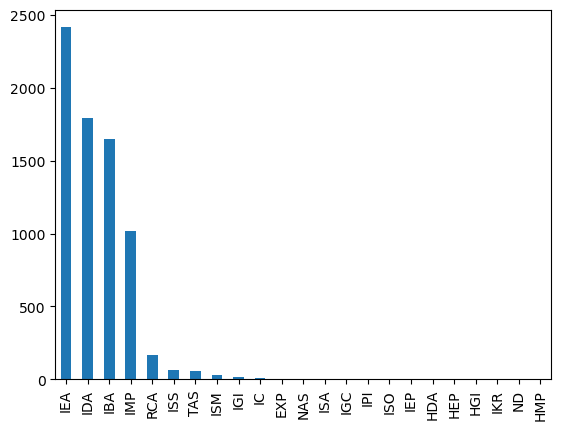

In [30]:
df_goa_uniprot_ecoli_tmtp.evidence_code.value_counts().plot.bar()


Creating subgraph for E. coli:

In [31]:
df_goa_uniprot_ecoli_tmtp = df_goa_uniprot_ecoli_tmtp.drop("evidence_code", axis=1).drop_duplicates().reset_index(drop=True)

In [32]:
annotations_to_go_term_ecoli =  df_goa_uniprot_ecoli_tmtp.groupby("go_id").apply(len).to_dict()
annotations_to_go_term_ecoli

{'GO:0000006': 1,
 'GO:0000064': 1,
 'GO:0000099': 9,
 'GO:0000102': 1,
 'GO:0001406': 2,
 'GO:0001761': 1,
 'GO:0003957': 1,
 'GO:0004129': 3,
 'GO:0005216': 30,
 'GO:0005244': 2,
 'GO:0005247': 2,
 'GO:0005253': 4,
 'GO:0005254': 2,
 'GO:0005261': 15,
 'GO:0005262': 1,
 'GO:0005267': 3,
 'GO:0005275': 2,
 'GO:0005280': 2,
 'GO:0005283': 3,
 'GO:0005287': 2,
 'GO:0005290': 2,
 'GO:0005291': 2,
 'GO:0005294': 1,
 'GO:0005295': 1,
 'GO:0005297': 1,
 'GO:0005298': 1,
 'GO:0005300': 1,
 'GO:0005302': 1,
 'GO:0005304': 3,
 'GO:0005310': 6,
 'GO:0005315': 6,
 'GO:0005337': 9,
 'GO:0005342': 86,
 'GO:0005343': 3,
 'GO:0005345': 8,
 'GO:0005350': 3,
 'GO:0005351': 13,
 'GO:0005353': 5,
 'GO:0005354': 5,
 'GO:0005355': 2,
 'GO:0005363': 5,
 'GO:0005372': 1,
 'GO:0005375': 2,
 'GO:0005381': 3,
 'GO:0005384': 3,
 'GO:0005385': 6,
 'GO:0005402': 16,
 'GO:0005412': 1,
 'GO:0005416': 5,
 'GO:0005432': 1,
 'GO:0005436': 1,
 'GO:0005452': 5,
 'GO:0005469': 3,
 'GO:0005477': 2,
 'GO:0008028': 24,
 'GO

In [33]:
graph_go_mf_tmtp_ecoli = graph_go_mf_tmtp_ecoli.subgraph(annotations_to_go_term_ecoli.keys())


In [34]:
for go_term, count in annotations_to_go_term_ecoli.items():
    graph_go_mf_tmtp_ecoli.nodes[go_term]["ecoli_count"] = count

In [35]:
graph_go_mf_tmtp_ecoli.nodes(data="ecoli_count")

NodeDataView({'GO:0042625': 7, 'GO:0015483': 1, 'GO:0015254': 1, 'GO:0008556': 4, 'GO:0008273': 1, 'GO:0005216': 30, 'GO:0015101': 19, 'GO:0015505': 2, 'GO:0015293': 82, 'GO:0005294': 1, 'GO:0009486': 6, 'GO:0015153': 1, 'GO:0015078': 62, 'GO:0015085': 1, 'GO:0005342': 86, 'GO:0015932': 11, 'GO:0022857': 480, 'GO:0015192': 2, 'GO:0015184': 4, 'GO:0140359': 41, 'GO:0015407': 5, 'GO:0015211': 2, 'GO:0015180': 1, 'GO:0015315': 3, 'GO:0015297': 35, 'GO:0022889': 4, 'GO:0090586': 1, 'GO:0015166': 3, 'GO:0015207': 2, 'GO:0015575': 1, 'GO:0015294': 51, 'GO:0015212': 4, 'GO:0015594': 2, 'GO:0019829': 15, 'GO:1901235': 1, 'GO:0008512': 1, 'GO:0015086': 4, 'GO:0005384': 3, 'GO:0033232': 1, 'GO:0005298': 1, 'GO:0015385': 6, 'GO:0005267': 3, 'GO:0071916': 19, 'GO:0022804': 240, 'GO:0090585': 3, 'GO:0015658': 4, 'GO:0140581': 1, 'GO:0015179': 31, 'GO:0140358': 7, 'GO:0005351': 13, 'GO:0009675': 1, 'GO:0022853': 80, 'GO:0015148': 2, 'GO:0022803': 55, 'GO:0008271': 2, 'GO:0015138': 5, 'GO:0090566': 2

## Plot

https://networkx.org/documentation/stable/reference/drawing.html#module-networkx.drawing.layout

In [36]:
nx.is_strongly_connected(graph_go_mf_tmtp_ecoli)

False

In [37]:
list(nx.strongly_connected_components(graph_go_mf_tmtp_ecoli))

[{'GO:0022857'},
 {'GO:0022804'},
 {'GO:0015399'},
 {'GO:0042626'},
 {'GO:0042625'},
 {'GO:0005342'},
 {'GO:0008514'},
 {'GO:0046943'},
 {'GO:0008028'},
 {'GO:0015245'},
 {'GO:0022803'},
 {'GO:0015267'},
 {'GO:0022829'},
 {'GO:0015288'},
 {'GO:0015483'},
 {'GO:0015144'},
 {'GO:1901618'},
 {'GO:0015166'},
 {'GO:0015168'},
 {'GO:0015254'},
 {'GO:0015075'},
 {'GO:0008324'},
 {'GO:0015318'},
 {'GO:0022890'},
 {'GO:0046873'},
 {'GO:1901702'},
 {'GO:0015079'},
 {'GO:0140358'},
 {'GO:0015662'},
 {'GO:0022853'},
 {'GO:0019829'},
 {'GO:0008556'},
 {'GO:0015081'},
 {'GO:0015085'},
 {'GO:0015291'},
 {'GO:0015297'},
 {'GO:0140828'},
 {'GO:0015368'},
 {'GO:0005432'},
 {'GO:0022821'},
 {'GO:0008273'},
 {'GO:0005216'},
 {'GO:0015101'},
 {'GO:0015205'},
 {'GO:0005350'},
 {'GO:0015210'},
 {'GO:0015293'},
 {'GO:0015294'},
 {'GO:0015391'},
 {'GO:0015505'},
 {'GO:0015171'},
 {'GO:0015175'},
 {'GO:0005294'},
 {'GO:0015453'},
 {'GO:0009486'},
 {'GO:0051119'},
 {'GO:0015145'},
 {'GO:0015149'},
 {'GO:0015153'

In [38]:
import random

    
def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5):

    '''
    From Joel's answer at https://stackoverflow.com/a/29597209/2966723.  
    Licensed under Creative Commons Attribution-Share Alike 
    
    If the graph is a tree this will return the positions to plot this in a 
    hierarchical layout.
    
    G: the graph (must be a tree)
    
    root: the root node of current branch 
    - if the tree is directed and this is not given, 
      the root will be found and used
    - if the tree is directed and this is given, then 
      the positions will be just for the descendants of this node.
    - if the tree is undirected and not given, 
      then a random choice will be used.
    
    width: horizontal space allocated for this branch - avoids overlap with other branches
    
    vert_gap: gap between levels of hierarchy
    
    vert_loc: vertical location of root
    
    xcenter: horizontal location of root
    '''
    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
        '''
        see hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        '''
    
        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos

            
    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)

{'GO:0042625': 7,
 'GO:0015483': 1,
 'GO:0015254': 1,
 'GO:0008556': 4,
 'GO:0008273': 1,
 'GO:0005216': 30,
 'GO:0015101': 19,
 'GO:0015505': 2,
 'GO:0015293': 82,
 'GO:0005294': 1,
 'GO:0009486': 6,
 'GO:0015153': 1,
 'GO:0015078': 62,
 'GO:0015085': 1,
 'GO:0005342': 86,
 'GO:0015932': 11,
 'GO:0022857': 480,
 'GO:0015192': 2,
 'GO:0015184': 4,
 'GO:0140359': 41,
 'GO:0015407': 5,
 'GO:0015211': 2,
 'GO:0015180': 1,
 'GO:0015315': 3,
 'GO:0015297': 35,
 'GO:0022889': 4,
 'GO:0090586': 1,
 'GO:0015166': 3,
 'GO:0015207': 2,
 'GO:0015575': 1,
 'GO:0015294': 51,
 'GO:0015212': 4,
 'GO:0015594': 2,
 'GO:0019829': 15,
 'GO:1901235': 1,
 'GO:0008512': 1,
 'GO:0015086': 4,
 'GO:0005384': 3,
 'GO:0033232': 1,
 'GO:0005298': 1,
 'GO:0015385': 6,
 'GO:0005267': 3,
 'GO:0071916': 19,
 'GO:0022804': 240,
 'GO:0090585': 3,
 'GO:0015658': 4,
 'GO:0140581': 1,
 'GO:0015179': 31,
 'GO:0140358': 7,
 'GO:0005351': 13,
 'GO:0009675': 1,
 'GO:0022853': 80,
 'GO:0015148': 2,
 'GO:0022803': 55,
 'GO:0008

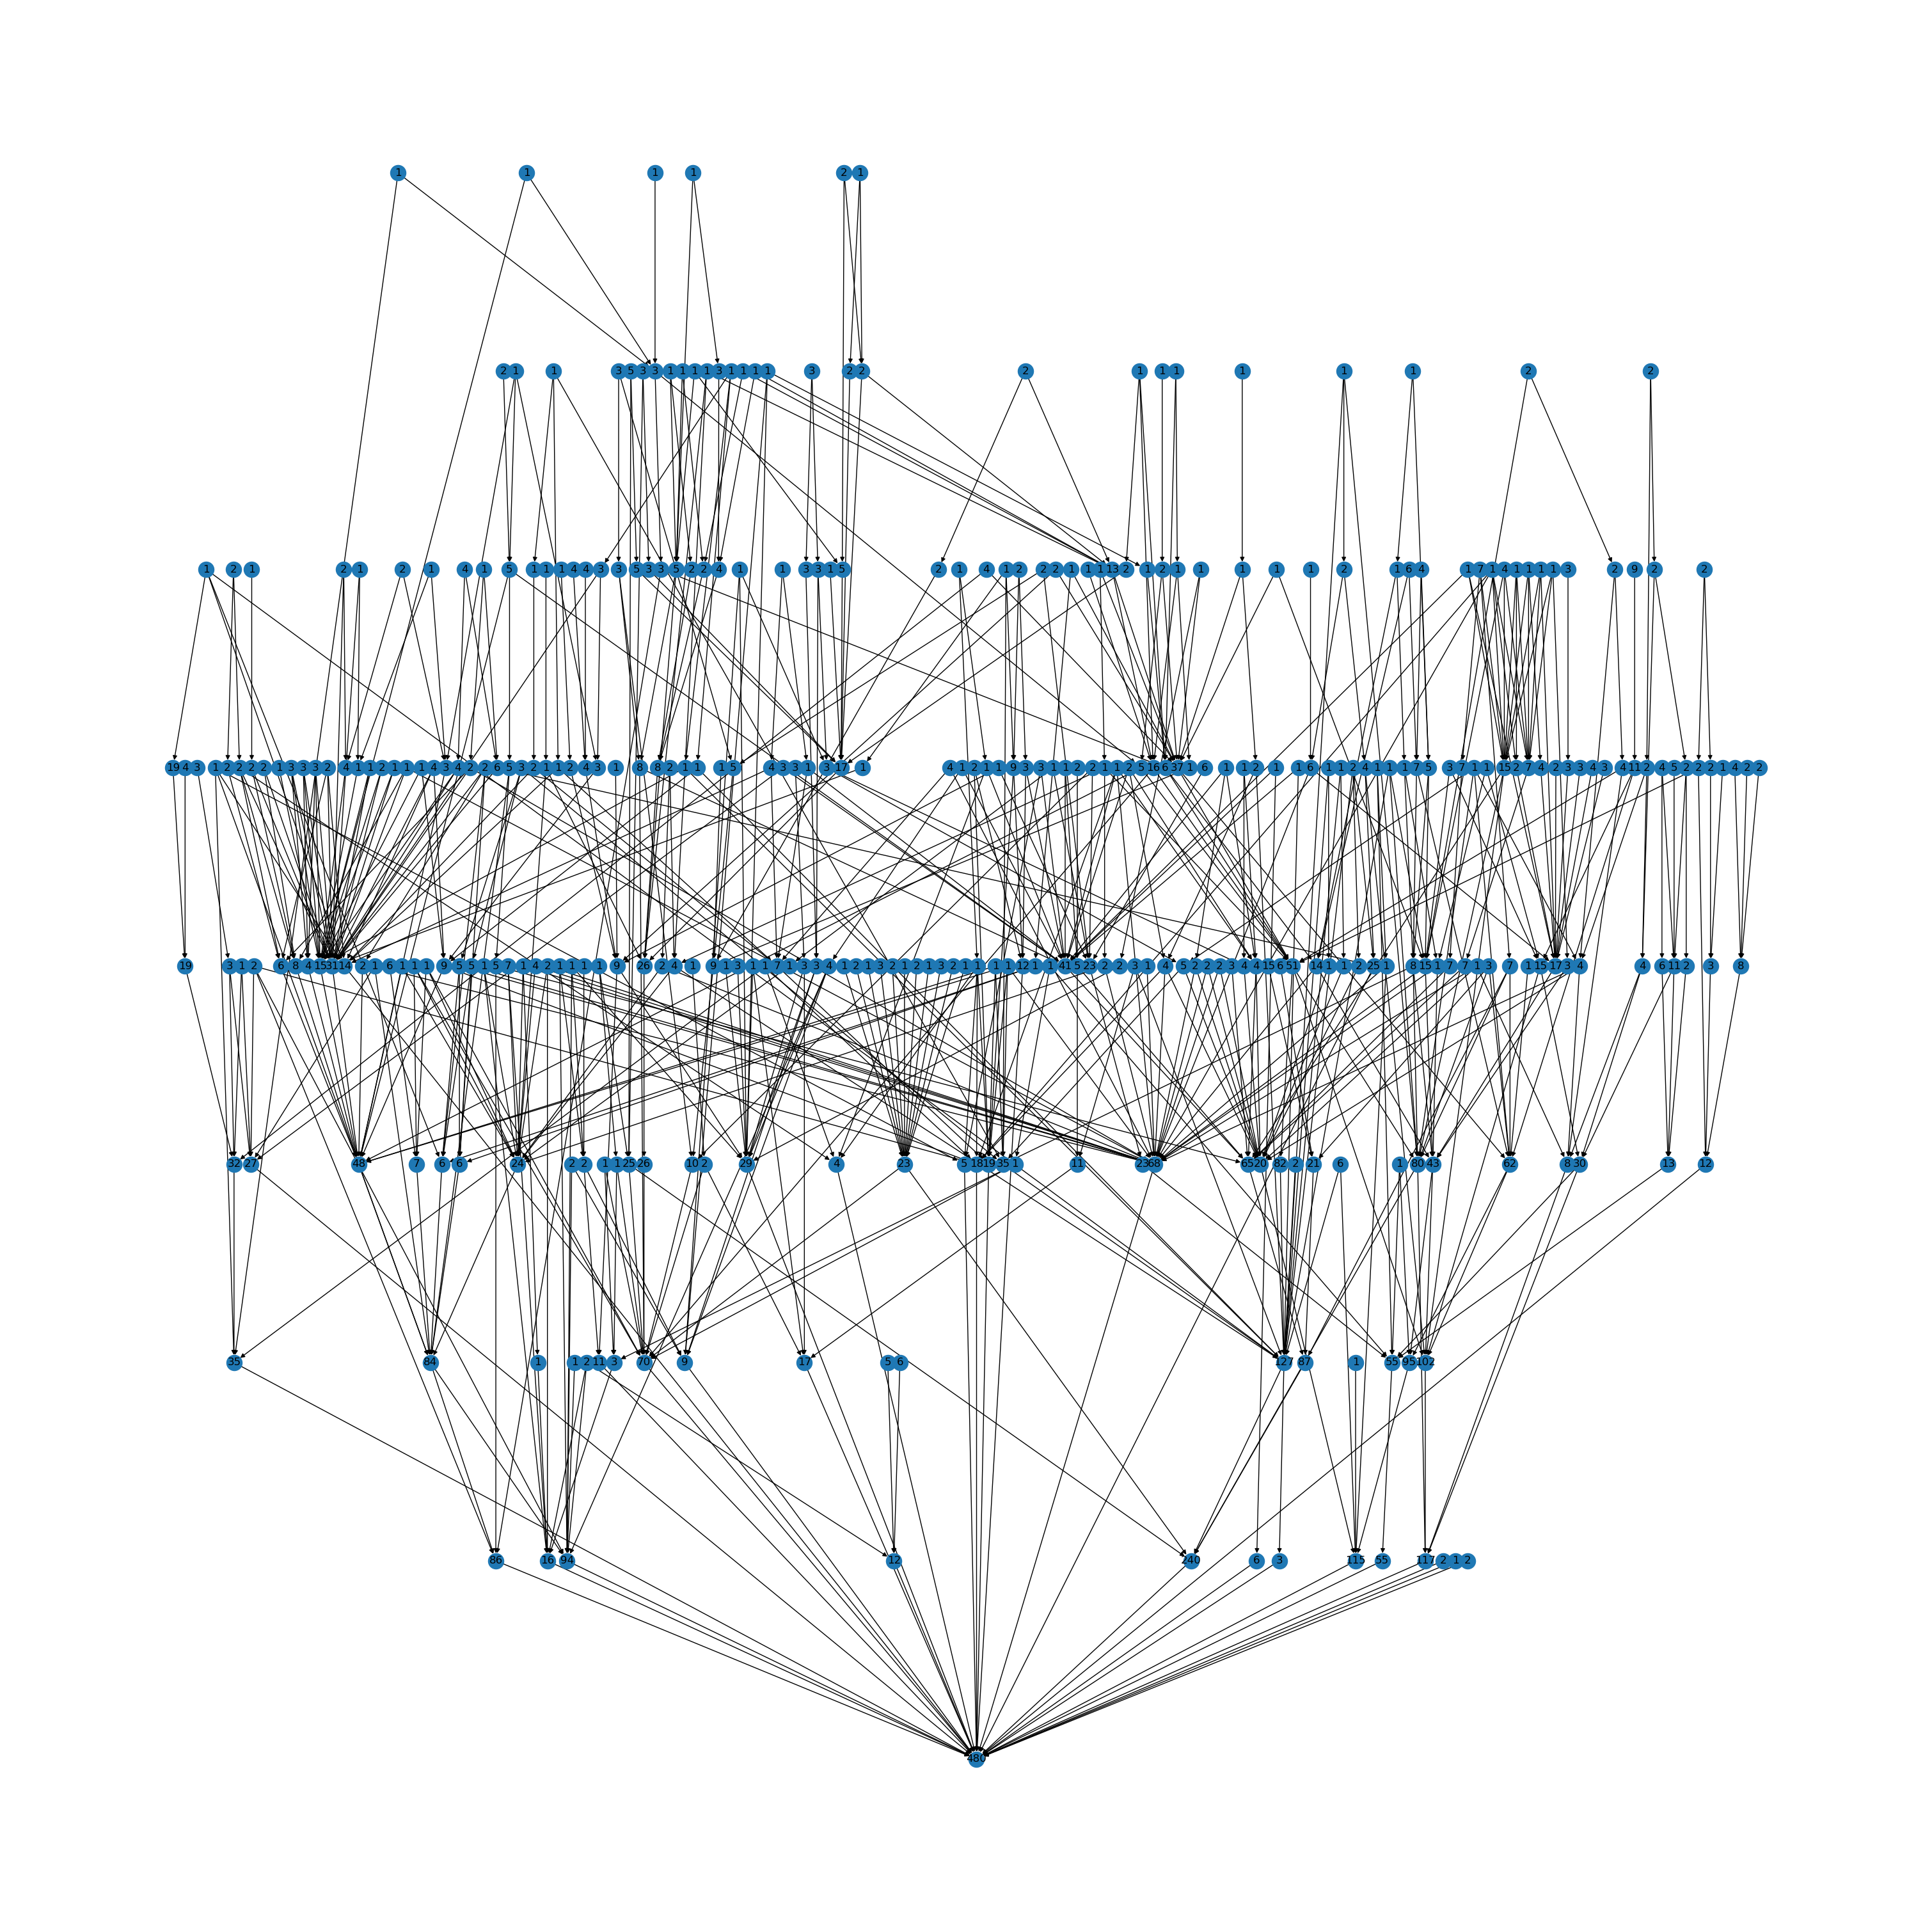

In [54]:
# TODO filter by more than 5 or 20
import matplotlib.pyplot as plt
plt.figure(3,figsize=(30,30))
# progs: dot, twopi, circo
layout = nx.nx_agraph.graphviz_layout(graph_go_mf_tmtp_ecoli, prog="dot")
labels = dict(graph_go_mf_tmtp_ecoli.nodes(data="ecoli_count"))
nx.draw(graph_go_mf_tmtp_ecoli,layout)
nx.draw_networkx_labels(graph_go_mf_tmtp_ecoli, pos=layout, labels=labels)
plt.show()

In [60]:
nodes_ge5_ecoli = {go_id for go_id, count in graph_go_mf_tmtp_ecoli.nodes(data="ecoli_count") if count >= 5}
graph_go_mf_tmtp_ecoli_ge5 = graph_go_mf_tmtp_ecoli.subgraph(nodes_ge5_ecoli)

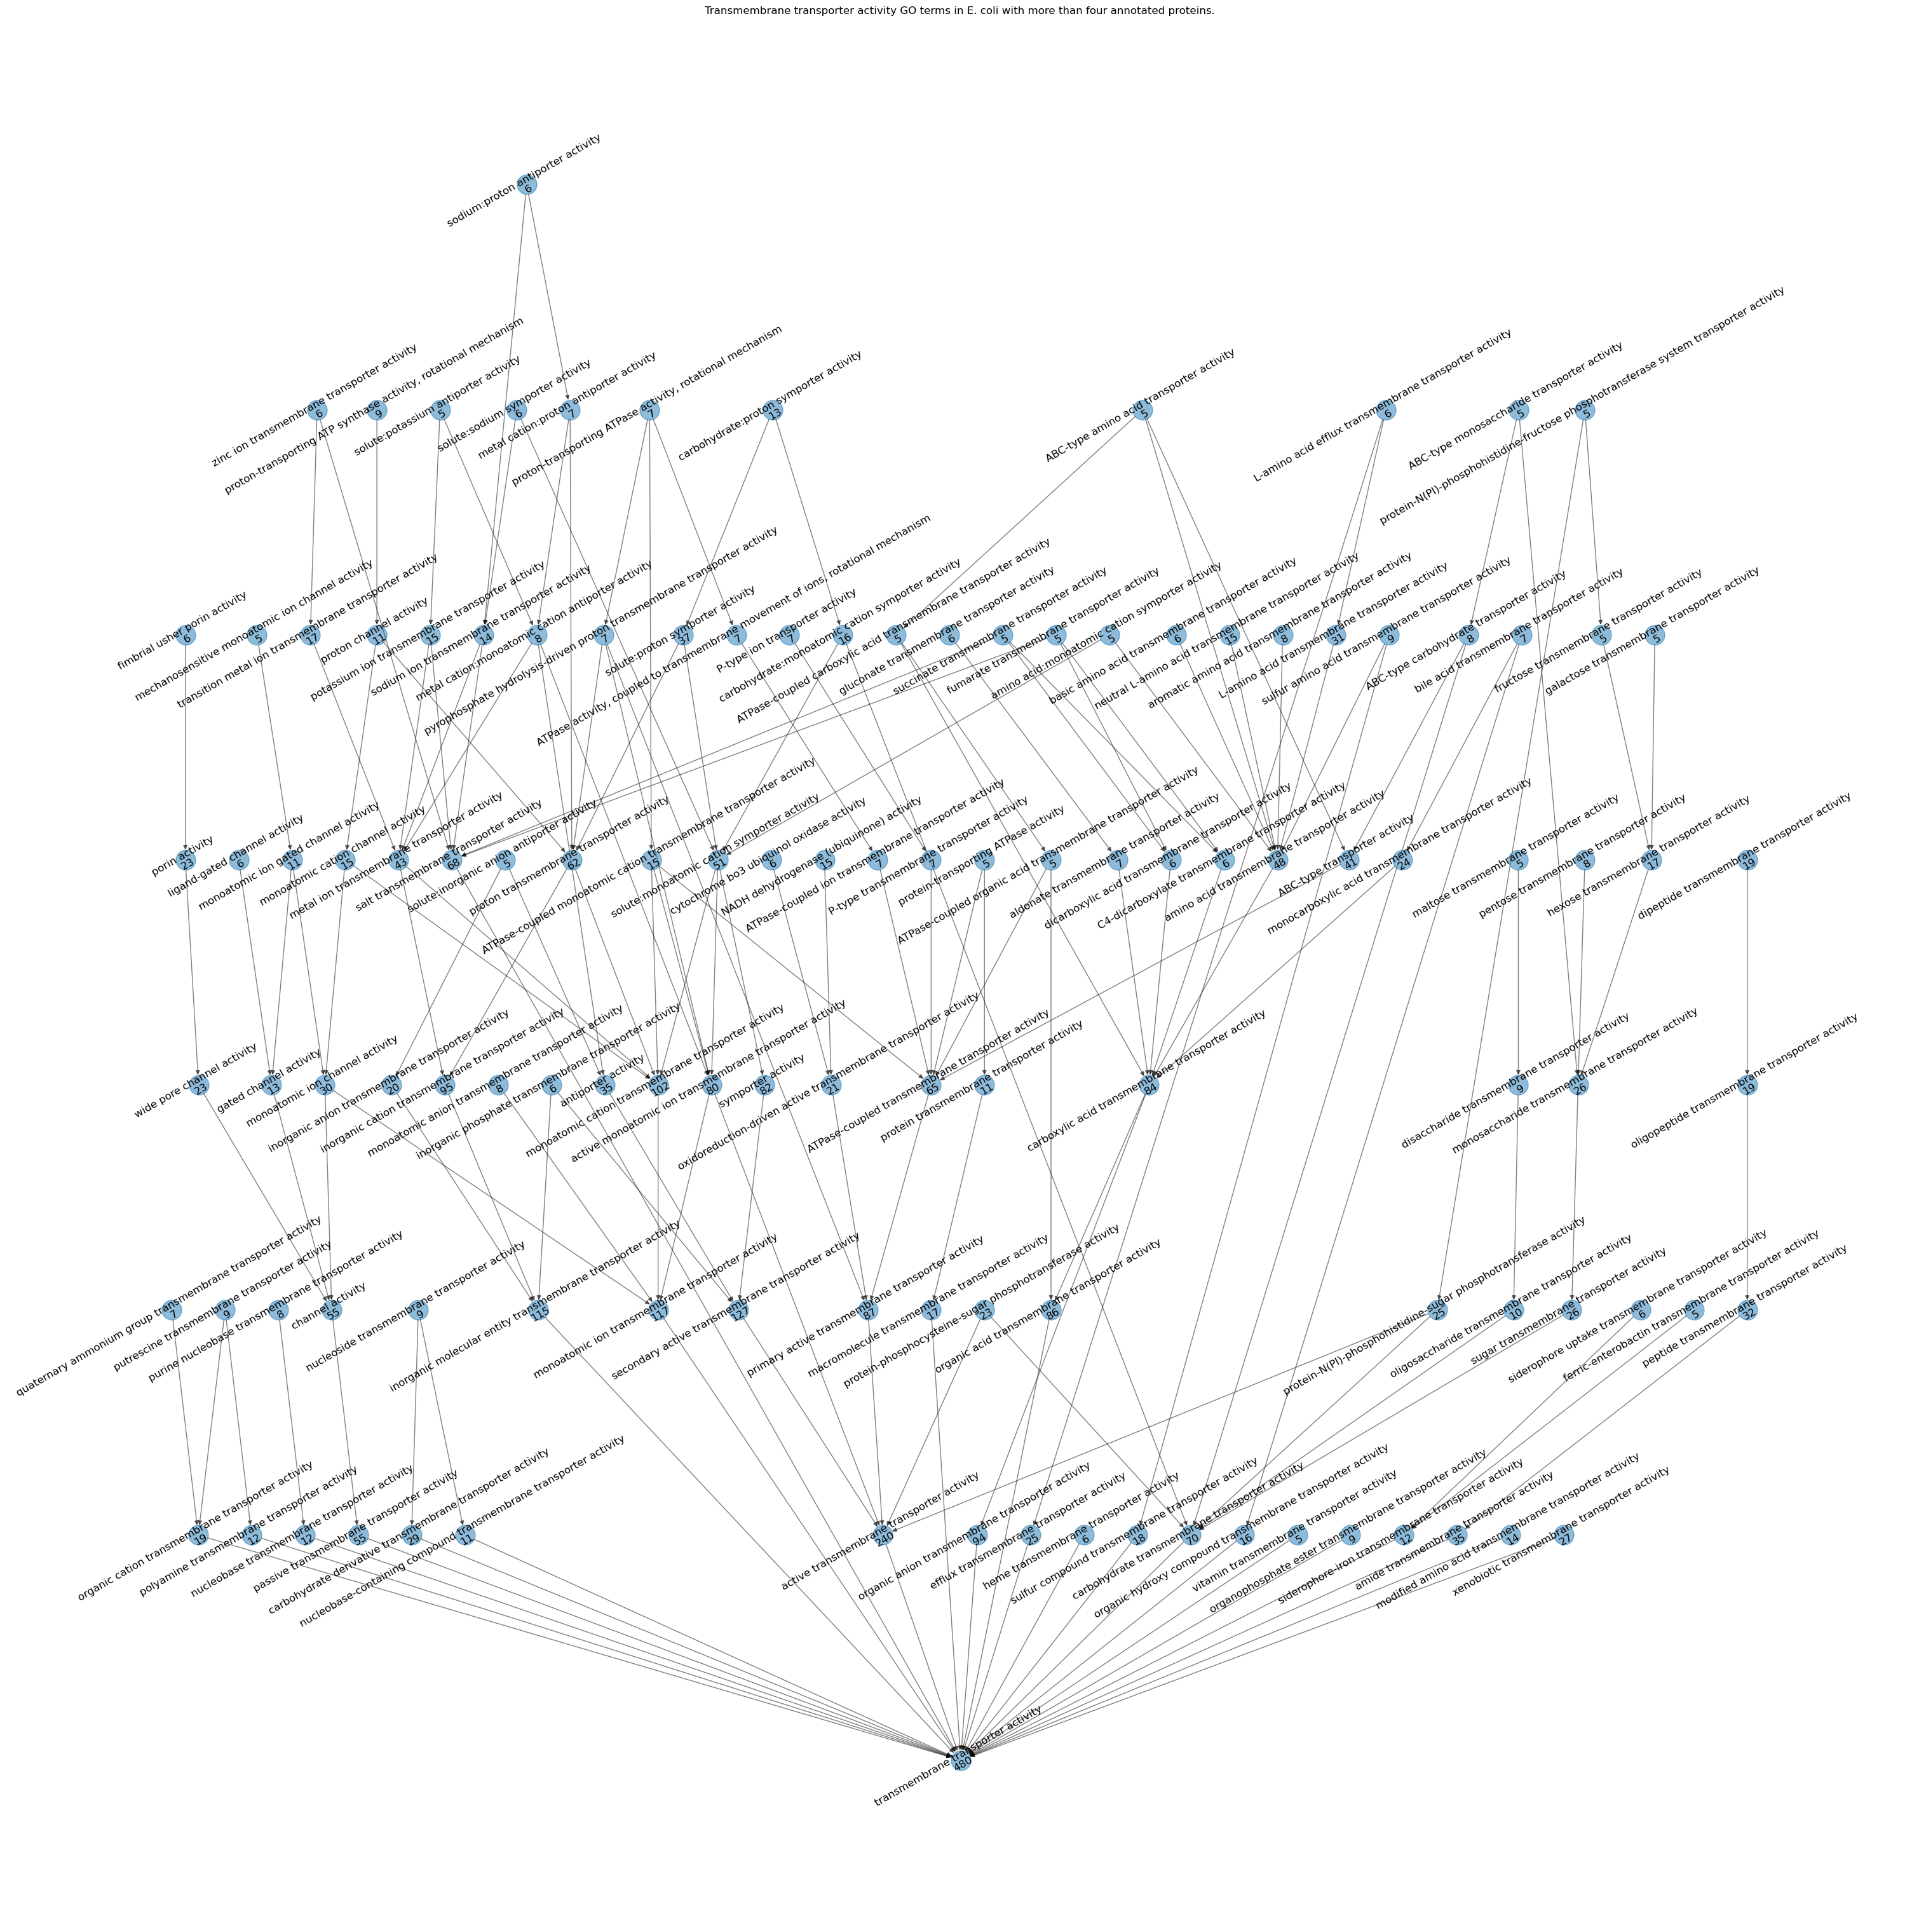

In [91]:
plt.figure(3,figsize=(30,30))

# progs: ‘dot’, ‘twopi’, ‘fdp’, ‘sfdp’, ‘circo’, neato
layout = nx.nx_agraph.graphviz_layout(graph_go_mf_tmtp_ecoli_ge5, prog="dot", root=name_to_id["transmembrane transporter activity"])
labels_name = dict(graph_go_mf_tmtp_ecoli_ge5.nodes(data="name"))
labels_count = dict(graph_go_mf_tmtp_ecoli_ge5.nodes(data="ecoli_count"))
# TODO node size
nx.draw(graph_go_mf_tmtp_ecoli_ge5,layout, alpha=0.5, node_size=500)
text = nx.draw_networkx_labels(graph_go_mf_tmtp_ecoli_ge5, pos=layout, labels=labels_count, verticalalignment="top")
for _, t in text.items():
    t.set_rotation(30)
    t.set_rotation_mode("anchor")
text = nx.draw_networkx_labels(graph_go_mf_tmtp_ecoli_ge5, pos=layout, labels=labels_name,verticalalignment="bottom")
for _, t in text.items():
    t.set_rotation(30)
    t.set_rotation_mode("anchor")

plt.title("Transmembrane transporter activity GO terms in E. coli with more than four annotated proteins.")
plt.show()

I could create a subgraph of transmembrane transporter activity, annotate each node with the number of proteins, then filter by that, and create a plot! A circle graph plot

In [ ]:
# TODO add root go term
